# <center>CSE 4/574: Introduction to Machine Learning</center>
## <center>Prof. Sargur Srihari</center>
### <center>Assignment 3</center>

In [382]:
# Imports
import gym
from gym import spaces
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random 
random.seed(42)

### Stock Trading Environment 

In [383]:
# Defining the Stock Trading Environment.
"""DON'T MAKE ANY CHANGES TO THE ENVIRONMENT."""


class StockTradingEnvironment(gym.Env):
    """This class implements the Stock Trading environment."""

    def __init__(self, file_path, train=True, number_of_days_to_consider=10):
        """This method initializes the environment.

        :param file_path: - Path of the CSV file containing the historical stock data.
        :param train: - Boolean indicating whether the goal is to train or test the performance of the agent.
        :param number_of_days_to_consider = Integer representing whether the number of days the for which the agent
                considers the trend in stock price to make a decision."""

        self.file_path = file_path  # Path of the CSV file containing the historical stock data.
        self.stock_data = pd.read_csv(self.file_path)  # Reading the CSV file containing the historical stock data.
        self.train = train  # Boolean indicating to use the training stock data by default.
        # Splitting the data into train and test datasets.
        self.training_stock_data = self.stock_data.iloc[:int(0.8 * len(self.stock_data))]
        self.testing_stock_data = self.stock_data.iloc[int(0.8 * len(self.stock_data)):].reset_index()
        self.observation_space = spaces.Discrete(4)  # This defines that there are four states in the environment.
        # This defines that there are 3 discrete actions that the agent can perform (Buy, Sell, Hold).
        self.action_space = spaces.Discrete(3)
        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # This defines the number of days for which the agent considers the data before taking an action.
        self.number_of_days_to_consider = number_of_days_to_consider
        # The maximum timesteps the agent will take before the episode ends.
        if self.train:
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider
        else:
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider
        # Initializing the number of steps taken to 0.
        self.timestep = 0
        self.reset()

    def reset(self):
        """This method resets the environment and returns the observation.

        :returns observation: - (Integer in the range of 0 to 3 representing the four possible observations that the
                                 agent can receive. The observation depends upon whether the price increased on average
                                 in the number of days the agent considers, and whether the agent already has the stock
                                 or not.)"""

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # Initializing the number of steps taken to 0.
        self.timestep = 0

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = 1
                price_decrease = 0
            else:
                price_increase = 0
                price_decrease = 1

            # Observation vector that will be passed to the agent.
            observation = [price_increase, price_decrease, 0, 1]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = 1
                price_decrease = 0
            else:
                price_increase = 0
                price_decrease = 1

            # Observation vector.
            observation = [price_increase, price_decrease, 0, 1]
        if np.array_equal(observation, [1, 0, 0, 1]):
            observation = 0
        if np.array_equal(observation, [1, 0, 1, 0]):
            observation = 1
        if np.array_equal(observation, [0, 1, 0, 1]):
            observation = 2
        if np.array_equal(observation, [0, 1, 1, 0]):
            observation = 3

        return observation

    def step(self, action):
        """This method implements what happens when the agent takes the action to Buy/Sell/Hold.

        :param action: - (Integer in the range 0 to 2 inclusive.)

        :returns observation: - (Integer in the range of 0 to 3 representing the four possible observations that the
                                 agent can receive. The observation depends upon whether the price increased on average
                                 in the number of days the agent considers, and whether the agent already has the stock
                                 or not.)
                 reward: - (Integer/Float value that's used to measure the performance of the agent.)
                 done: - (Boolean describing whether or not the episode has ended.)
                 info: - (A dictionary that can be used to provide additional implementation information.)"""

        # We give the agent a penalty for taking actions such as buying a stock when the agent doesn't have the
        # investment capital and selling a stock when the agent doesn't have any shares.
        penalty = 0

        if self.train:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.training_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value +=\
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider]\
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        else:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.testing_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = self.training_stock_data['Open'][
                                           self.timestep + self.number_of_days_to_consider] * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        # Determining if the agent currently has shares of the stock or not.
        if self.number_of_shares > 0:
            stock_held = 1
            stock_not_held = 0
        else:
            stock_held = 0
            stock_not_held = 1

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = 1
                price_decrease = 0
            else:
                price_increase = 0
                price_decrease = 1

            # Observation vector.
            observation = [price_increase, price_decrease, stock_held, stock_not_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = 1
                price_decrease = 0
            else:
                price_increase = 0
                price_decrease = 1

            # Observation vector.
            observation = [price_increase, price_decrease, stock_held, stock_not_held]

        self.timestep += 1  # Increasing the number of steps taken by the agent by 1.

        if np.array_equal(observation, [1, 0, 0, 1]):
            observation = 0
        if np.array_equal(observation, [1, 0, 1, 0]):
            observation = 1
        if np.array_equal(observation, [0, 1, 0, 1]):
            observation = 2
        if np.array_equal(observation, [0, 1, 1, 0]):
            observation = 3

        # Computing the total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # Appending the total account value of the list to plot the graph.
        self.total_account_value_list.append(self.total_account_value)
        
        # The episode terminates when the number of infected people becomes greater than 75 % of the population.
        done = True if (self.timestep >= self.max_timesteps) \
            else False
        
        info = {}
        return observation, reward, done, info

    def render(self, mode='human'):
        """This method renders the agent's total account value over time.

        :param mode: 'human' renders to the current display or terminal and returns nothing."""
        
        plt.figure(figsize=(15, 10))
        plt.plot(self.total_account_value_list, color='lightseagreen', linewidth=7)
        plt.xlabel('Days', fontsize=32)
        plt.ylabel('Total Account Value', fontsize=32)
        plt.title('Total Account Value over Time', fontsize=38)
        plt.grid()
        plt.show()

### TO DO: Implement the Q-learning algorithm 

In [407]:
# Implementing Q-Learning for the stock trading environment.
class QLearning:

    def __init__(self, environment):

        # Creating the Q-table 
        self.environment = environment
        self.action_size = environment.action_space.n
        self.state_size = environment.observation_space.n
        self.q_table = np.zeros((self.state_size, self.action_size))  # Size of Q-table is set to state_size x action_size
        self.reward_list = []
        self.epsilon_decay = []
        

    def train(self):
                
        # Initializing hyper-parameters
        learning_rate = 0.95                                          # Learning rate 
        gamma = 0.9                                                   # Discounting rate
        total_episodes = 1000                                         # Total no. of episodes until the end
        max_steps_per_episode = 10                                    # Maximum steps allowed per episode

        # Exploration parameters
        epsilon = 1.0                                                 # Exploration rate
        max_epsilon = 1.0                                             # Maximum limit of exploration
        min_epsilon = 0.01                                            # Minimum limit of exploration 
        decay_rate = 0.005                                            # Exponential decay rate of exploration
        
        
        for ep in range(total_episodes):
            state = self.environment.reset()
            #step = 0
            done = False
            current_ep_rewards = 0

            for step in range(max_steps_per_episode):
                
                # A random threshold is set as trade-off between exploration and exploitation
                exp_exp_rate_threshold = random.uniform(0, 1)

                # If this threshold > epsilon value --> EXPLOITATION (taking the biggest Q value for this state)
                if exp_exp_rate_threshold > epsilon:
                    action = np.argmax(self.q_table[state,:])

                # Else a random action is picked (buy/sell/hold) --> EXPLORATION
                else:
                    action = self.environment.action_space.sample()

                # Action (a) is taken and the outcome state(s') and reward (r) are observed
                new_state, reward, done, info = self.environment.step(action)

                # Update Q-table values using the formula:  Q(s,a):= (1 - lr)Q(s,a) + lr [R(s,a) + gamma * max Q(s',a')]
                self.q_table[state, action] = ((1 - learning_rate) * self.q_table[state, action]) + learning_rate * (reward + gamma * np.max(self.q_table[new_state, :]))
                current_ep_rewards += reward

                # Updating state variable with the new state
                state = new_state

                # finish episode
                if done == True: 
                    break

            # Epsilon is decayed to encourage less exploration and more exploitation based on the updated Q-table values
            epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*ep) 
            self.epsilon_decay.append(epsilon)
            self.reward_list.append(current_ep_rewards)
            
        # Calculate and print avg. reward per 100 episodes (rewards should increase)
        ep_count = 100
        count = ep_count
        rewards_in_sets = np.split(np.array(self.reward_list), total_episodes/ep_count)
        
        print("Average reward per ", ep_count, "episodes:")
        for r in rewards_in_sets:
            print(count, ":", str(sum(r/ep_count)))
            count += ep_count
            

    def evaluate(self):

        self.environment.train = False
        self.environment.reset()
        
        max_steps_per_episode = 100

        for ep in range(1):
            state = self.environment.reset()
            step = 0
            done = False

            for step in range(max_steps_per_episode):
                
                # Action with the most expected future cummulative reward (given that state) is taken
                action = np.argmax(self.q_table[state,:])

                new_state, reward, done, info = self.environment.step(action)
                state = new_state
        
        # Final stock value is printed
        print("Final Stock Value:", self.environment.total_account_value_list[-1])        
        self.environment.close()
        

    def plot(self,):
        
        # Plotting Total Stock value against Days
        self.environment.render() 
        
        # Plotting Epsilon Decay plot
        plt.figure(figsize=(15, 10))
        plt.plot(self.epsilon_decay, color='lightcoral', linewidth=7)
        plt.xlabel('Episodes', fontsize=32)
        plt.ylabel('Epsilon Value', fontsize=32)
        plt.title('Epsilon Decay Plot', fontsize=38)
        plt.grid()
        plt.show()

        # Plotting Rewards Vs Episodes
        x = []
        for e in range(1,len(self.reward_list)+1):
            x.append(e)
            
        plt.figure(figsize=(15, 10))
        plt.scatter(x, self.reward_list, color='mediumorchid', s=30)
        plt.xlabel('Episodes', fontsize=32)
        plt.ylabel('Rewards', fontsize=32)
        plt.title('Total Reward over Episodes', fontsize=38)
        plt.grid()
        plt.show()
        print ("Score over time: " +  str(sum(self.reward_list)/1000)) #where total no. of episodes = 1000
        print(self.q_table)
        
        



Average reward per  100 episodes:
100 : 4.86418075425284
200 : 22.498126672167437
300 : 57.65796007970613
400 : 82.15277411278612
500 : 105.28622957113092
600 : 127.13443832241181
700 : 108.12634787569155
800 : 127.65090373827552
900 : 132.56639526626262
1000 : 139.32893040693943
Final Stock Value: 149981.190679
100


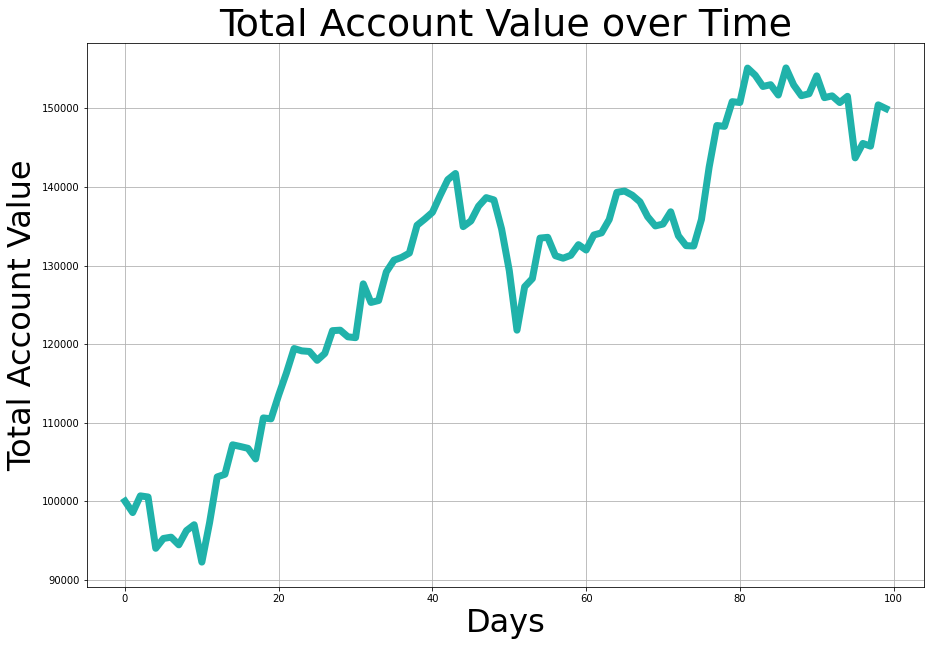

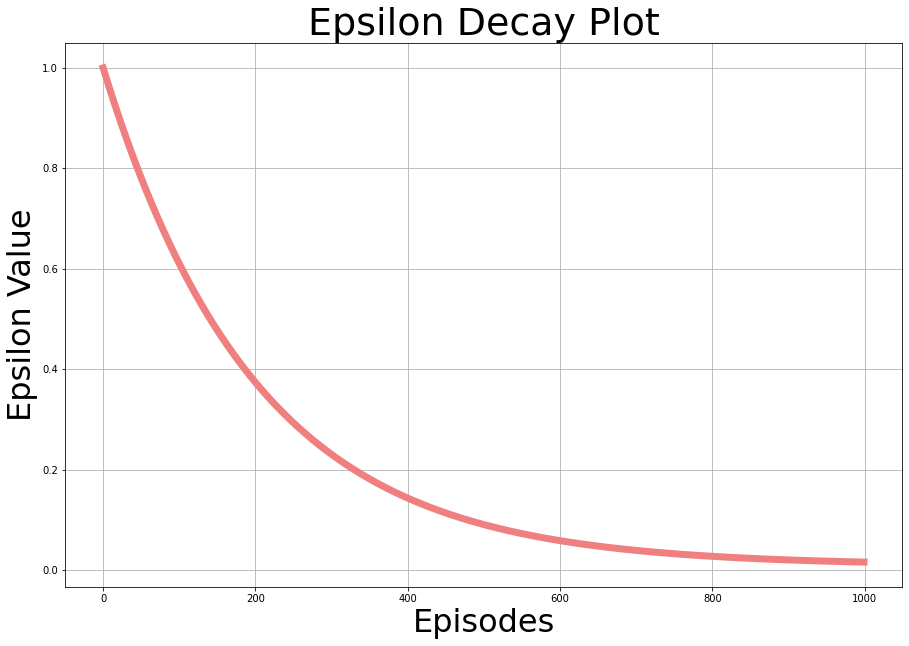

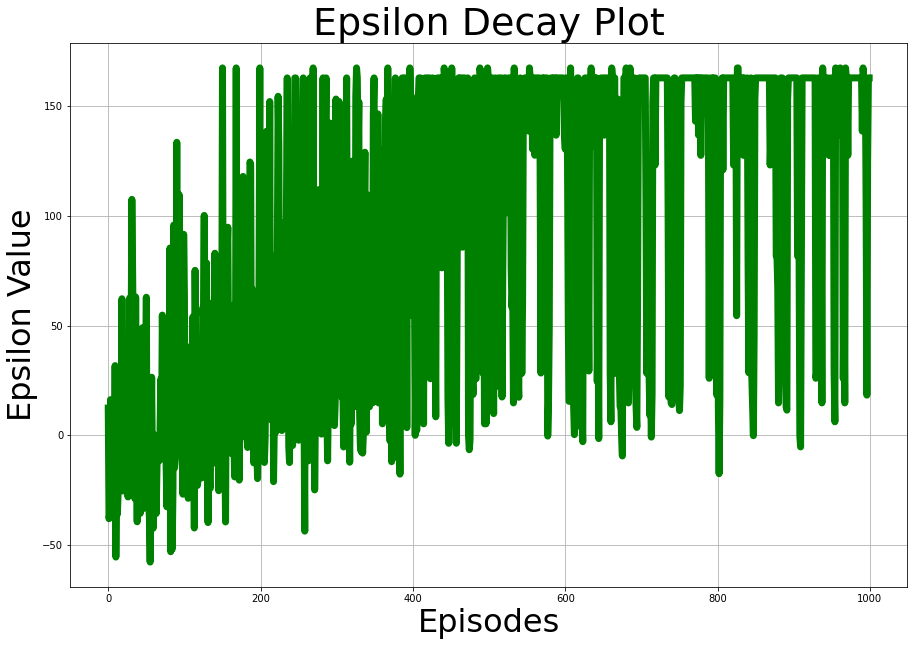

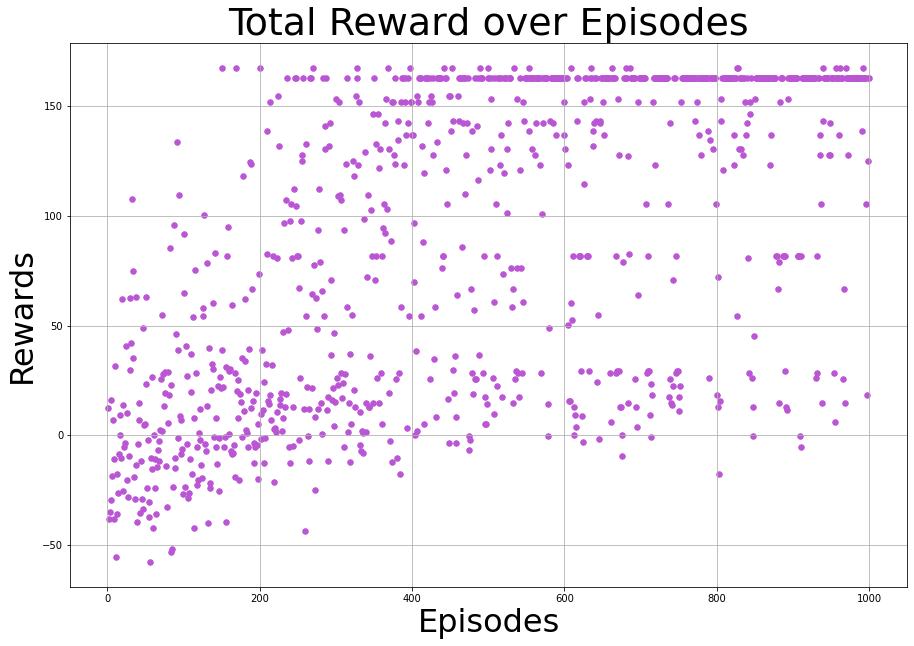

Score over time: 90.72662867996245
[[172.94114361  88.14567507  65.38208831]
 [124.36279052 112.4521269  199.81398018]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]


In [411]:
stock_trading_environment = StockTradingEnvironment('./NVDA.csv', number_of_days_to_consider=130)
agent = QLearning(stock_trading_environment)
agent.train()
agent.evaluate()
agent.plot()